### Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv("dataset/output_v4.csv", encoding='latin-1')

In [3]:
#Removing the null values
df = df.dropna()
print(df.isna().sum())

PATH     0
VALUE    0
LABEL    0
dtype: int64


In [4]:
value_counts = df['LABEL'].value_counts()
print(value_counts)

DESCRIPTION    2023
CVE            2000
SEVERITY       1966
Name: LABEL, dtype: int64


In [5]:
df['PATH'] = df['PATH'].str.replace('.', ' ').str.lower()
df['VALUE'] = df['VALUE'].str.replace('\d+', 'number', regex=True)


C:\Users\Abdul Hakkam\AppData\Local\Temp\ipykernel_22380\3479448783.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['PATH'] = df['PATH'].str.replace('.', ' ').str.lower()


In [6]:
df['text'] = df["PATH"].astype(str) + " " +df["VALUE"].astype(str)
df['label'] = df["LABEL"]

In [7]:
df.head()

,PATH,VALUE,LABEL,text,label
0,data[] component_versions more_details cve,CVE-number-number,CVE,data[] component_versions more_details cve CVE...,CVE
1,data[] component_versions more_details cves[] cve,CVE-number-number,CVE,data[] component_versions more_details cves[] ...,CVE
2,data[] component_versions more_details cves[] cve,CVE-number-number,CVE,data[] component_versions more_details cves[] ...,CVE
3,data[] component_versions more_details cve,CVE-number-number,CVE,data[] component_versions more_details cve CVE...,CVE
4,artifacts[] issues[] cves[] idartifacts[] issu...,CVE-number-number,CVE,artifacts[] issues[] cves[] idartifacts[] issu...,CVE


# Word2vec

In [8]:
import gensim
from sklearn.cluster import KMeans

In [9]:
tokenized_texts = [text.split() for text in df["text"].tolist()]

In [10]:
w2vModel = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, sg=0)

In [11]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0

    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)

    return feature_vector

In [12]:
vocab_wv = w2vModel.wv.index_to_key


In [13]:
vectorized_texts = [average_word_vectors(text, w2vModel, vocab_wv, 100) for text in tokenized_texts]

In [14]:
print(len(vectorized_texts))

5989


# KMEANS

In [15]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(vectorized_texts)

c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [16]:
# wcss = []

# k_values = range(1, 20)

# # Calculate WCSS for each K
# for k in k_values:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(vectorized_texts)
#     wcss.append(kmeans.inertia_)

# # Plot the WCSS values
# plt.figure(figsize=(8, 4))
# plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
# plt.title('WCSS vs. Number of Clusters (K)')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
# plt.grid()
# plt.show()


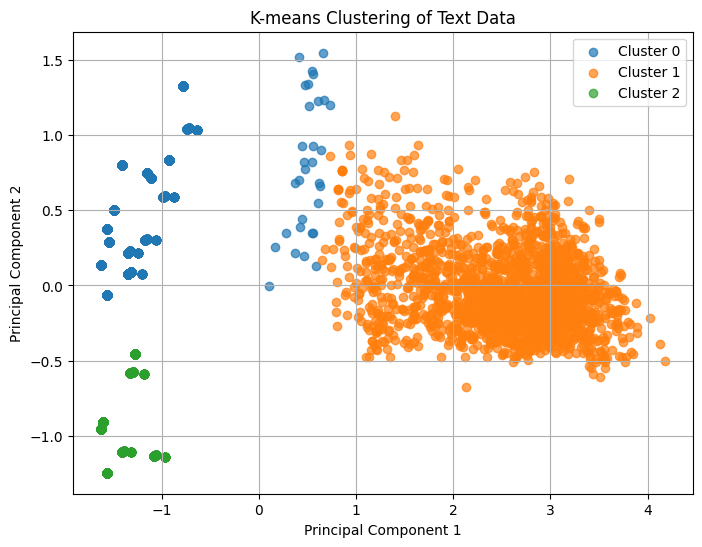

In [17]:
from sklearn.decomposition import PCA

# Assuming you have already performed K-means clustering and have cluster labels
# Replace 'cluster_labels' with your actual cluster labels
cluster_labels = kmeans.labels_  # Replace with your cluster labels

# Reduce the dimensionality of your vectorized texts for plotting (e.g., using PCA)
pca = PCA(n_components=2)  # You can adjust the number of components as needed
vectorized_texts_2d = pca.fit_transform(vectorized_texts)

# Plot the clusters
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(8, 6))

for label in unique_labels:
    plt.scatter(
        vectorized_texts_2d[cluster_labels == label, 0],
        vectorized_texts_2d[cluster_labels == label, 1],
        label=f'Cluster {label}',
        alpha=0.7,
    )

plt.title('K-means Clustering of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [18]:
distances = kmeans.transform(vectorized_texts)

In [19]:
print(distances)

[[1.79793699 4.29076897 0.49378744]
 [1.53619772 4.28119742 0.50508567]
 [1.53619772 4.28119742 0.50508567]
 ...
 [0.63343279 3.75644105 1.10790848]
 [1.28234082 3.80729103 0.62972878]
 [0.98827782 3.83542543 1.79254151]]


# MODEL - LSTM

In [20]:
df = df.sort_values(by='label', ascending=True, ignore_index= True)
columns = df['label'].unique()

In [21]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
int_encoded = label_encoder.fit_transform(df['label'].values)

In [22]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the integer encoded labels
one_hot_encoded = to_categorical(int_encoded, num_classes=3)


In [23]:
df = df.dropna()

In [24]:
one_hot_df = pd.DataFrame(one_hot_encoded, columns=df['label'].unique())

In [25]:
# Concatenate this new DataFrame with the original df
df = pd.concat([df.drop('label', axis=1), one_hot_df], axis=1)

In [26]:
df.head()

,PATH,VALUE,LABEL,text,CVE,DESCRIPTION,SEVERITY
0,data[] component_versions more_details cve,CVE-number-number,CVE,data[] component_versions more_details cve CVE...,1.0,0.0,0.0
1,data[] component_versions more_details cves[] cve,CVE-number-number,CVE,data[] component_versions more_details cves[] ...,1.0,0.0,0.0
2,data[] component_versions more_details cve,CVE-number-number,CVE,data[] component_versions more_details cve CVE...,1.0,0.0,0.0
3,data[] component_versions more_details cves[] ...,CVE-number-number,CVE,data[] component_versions more_details cves[] ...,1.0,0.0,0.0
4,artifacts[] issues[] cves[] id,CVE-number-number,CVE,artifacts[] issues[] cves[] id CVE-number-number,1.0,0.0,0.0


In [27]:
df = df.dropna()

In [28]:
#splitting data into train, validation and test sets. 80 10 10 split.
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [29]:
# #Convert the pandas dataframe into tensorflow dataset
# def df_to_dataset(dataframe, batch_size=1024):
#   df = dataframe.copy()
#   labels = df.pop('label')
#   df = df["text"]
#   ds = tf.data.Dataset.from_tensor_slices((df, labels))
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(tf.data.AUTOTUNE)
#   return ds
def df_to_dataset(dataframe, batch_size=1024, input = 'text'):
    df = dataframe.copy()
    label_columns = columns # Adjust based on your label column names
    labels = df[label_columns]
    df = df.drop(label_columns, axis=1)  # Drop label columns
    df = df[input]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [30]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [31]:
ds_labels = [labels for _, labels in train_data.unbatch()]

In [32]:
#creating a text vectorization layer
encoder = tf.keras.layers.TextVectorization(max_tokens=4001)
encoder.adapt(train_data.map(lambda text, label: text))

In [33]:
#Ensuring the vocabulary produced by the encoder is correct
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'data', 'cves', 'cvenumbernumber', 'to', 'the', 'a',
       'severity', 'in', 'issues', 'artifacts', 'allows', 'advisories',
       'vulnerabilities', 'high', 'results', 'description', 'and',
       'remote'], dtype='<U60')

In [90]:
CNN = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32
    ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPooling1D(), 
    tf.keras.layers.Dense(3, activation='softmax')
])

In [88]:
CNN_V2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64 
    ),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(3, activation='softmax')
])

In [35]:
BiLSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [36]:
#creating a model with embedding layer, LSTM layer and dense layer
LSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [89]:
model = CNN

In [79]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=1,
    restore_best_weights=True,
)

In [80]:
#training the model
history = model.fit(train_data, epochs=30,validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/30


5/5 [==============================] - 2s 202ms/step - loss: 0.9739 - accuracy: 0.5352 - val_loss: 1.0879 - val_accuracy: 0.5376
Epoch 2/30
5/5 [==============================] - 1s 136ms/step - loss: 0.4097 - accuracy: 0.8405 - val_loss: 1.0811 - val_accuracy: 0.5609
Epoch 3/30
5/5 [==============================] - 1s 140ms/step - loss: 0.1872 - accuracy: 0.9539 - val_loss: 1.0711 - val_accuracy: 0.5760
Epoch 4/30
5/5 [==============================] - 1s 131ms/step - loss: 0.0635 - accuracy: 0.9917 - val_loss: 1.0568 - val_accuracy: 0.6578
Epoch 5/30
5/5 [==============================] - 1s 142ms/step - loss: 0.0229 - accuracy: 0.9973 - val_loss: 1.0390 - val_accuracy: 0.6578
Epoch 6/30
5/5 [==============================] - 1s 133ms/step - loss: 0.0093 - accuracy: 0.9987 - val_loss: 1.0201 - val_accuracy: 0.6578
Epoch 7/30
5/5 [==============================] - 1s 138ms/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 1.0014 - val_accuracy: 0.6578
Epoch 8/30
5/5 [===============

# Part D - Testing


keras model.evaluate returns loss and accuracy metrics for the model (https://keras.io/api/models/model_training_apis/#evaluate-method)

In [82]:
model.evaluate(test_data)

1/1 [==============================] - 0s 37ms/step - loss: 0.5672 - accuracy: 0.9800


[0.5671855211257935, 0.9799666404724121]

The history of the model during training is used to plot a graph of the validation accuracy and the training accuracy to check for overfitting issues

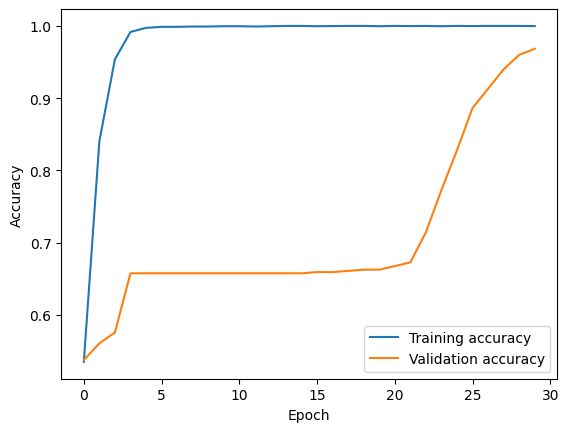

In [83]:
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

A confusion matrix is used to visualize how well the model performs for both classes. Here the test values are used to get predictions and are validated against the true labels.

1/1 [==============================] - 0s 174ms/step
[0 2 1 1 0 1 2 2 1 1 1 2 0 1 2 2 0 1 0 0 0 2 0 1 1 1 2 2 2 0 1 2 0 0 2 0 1
 0 1 1 2 2 0 0 0 2 1 1 0 1 0 2 2 2 1 2 0 1 0 2 0 0 2 0 0 1 1 2 2 1 0 1 2 0
 1 0 2 0 0 0 0 2 2 2 0 1 0 2 0 2 0 2 1 1 2 0 2 1 2 2 1 0 2 2 2 2 1 1 0 1 2
 2 1 2 2 2 1 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 1 1 0 1 2 0 2 2 1 2 1 2 1 0 2 1
 0 2 2 0 2 1 1 0 2 0 0 0 2 2 0 0 0 0 0 2 1 0 2 1 0 2 2 1 0 2 1 2 1 1 0 0 0
 2 2 0 1 2 2 0 1 1 0 2 0 0 2 0 0 0 1 1 0 1 1 2 0 2 2 2 0 0 2 0 1 2 0 0 0 1
 2 1 1 0 2 1 1 2 2 0 0 2 0 2 0 1 2 2 2 1 2 0 0 0 2 0 0 1 2 2 0 0 1 0 0 0 2
 0 0 0 2 1 2 1 0 2 0 1 0 0 0 1 1 1 2 2 1 2 2 0 2 0 1 1 2 2 1 2 0 2 0 1 0 2
 1 0 0 2 2 0 2 2 1 0 0 2 2 1 0 2 0 1 2 0 1 2 1 2 1 2 1 1 0 0 0 0 2 2 1 1 1
 0 1 0 0 0 0 2 1 0 0 0 0 0 0 0 0 2 2 0 2 1 0 2 0 1 1 1 0 2 2 0 1 2 0 1 1 0
 2 1 1 0 2 0 1 2 0 2 0 0 0 2 0 1 2 2 0 0 0 1 2 1 1 2 1 2 0 2 2 2 2 2 1 0 1
 2 2 1 2 1 0 2 1 1 0 1 2 2 0 0 1 1 1 2 0 2 2 2 0 1 1 0 0 2 1 2 2 0 2 0 2 2
 0 2 0 1 1 0 0 1 2 2 0 2 1 0 1 0 1 2 2 2 2 1 0 

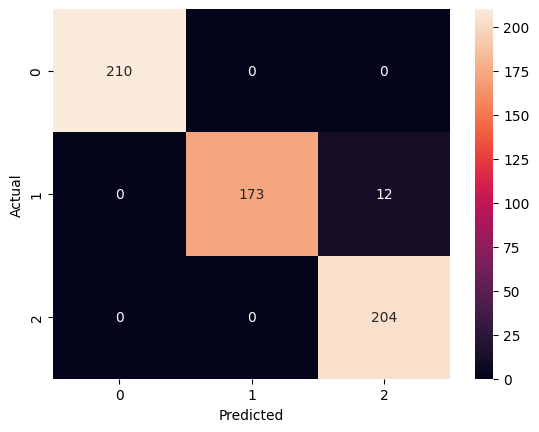

In [84]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import seaborn as sns

# predicted_labels = np.argmax(model_outputs, axis=1)
# Build and show confusion matrix
y_test = np.concatenate([y for x, y in test_data], axis=0)
true_labels = np.argmax(y_test, axis=1)
y_pred = model.predict(test_data)
predicted_labels = np.argmax(y_pred, axis=1)

print(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



The accuracy, precision and recall score are printed out here.
- Accuracy measures the overall correctness of the model by calculating the ratio of correctly predicted instances to the total instances
- Precision assesses the accuracy of the positive predictions made by the model
- Recall measures the ability of the model to capture all the positive instances.

In [48]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=300, max_samples='auto', contamination=float(0.03), random_state=42)
iso_forest.fit(vectorized_texts)

IsolationForest(contamination=0.03, n_estimators=300, random_state=42)

In [85]:
tokenized_test = [text.split() for text in ['vulnerabilities[] id severity low']]
vectorized_test = [average_word_vectors(text, w2vModel, vocab_wv, 100) for text in tokenized_test]
is_outlier = iso_forest.predict(vectorized_test)[0] == -1
print(is_outlier)

False


In [86]:
prediction = model.predict(["vulnerabilities[] severity low"])
print(prediction)

AbortedError: Graph execution error:

Detected at node sequential_5/max_pooling1d_6/MaxPool defined at (most recent call last):
  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\Abdul Hakkam\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\Abdul Hakkam\AppData\Local\Temp\ipykernel_22380\3584312805.py", line 1, in <module>

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\pooling\base_pooling1d.py", line 76, in call

  File "c:\Users\Abdul Hakkam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py", line 6642, in pool2d

Compute received an exception:Status: 2, message: could not create a descriptor for a pooling forward propagation primitive, in file tensorflow/core/kernels/mkl/mkl_maxpooling_op.cc:211
	 [[{{node sequential_5/max_pooling1d_6/MaxPool}}]] [Op:__inference_predict_function_45214]

In [ ]:
# import joblib
# joblib.dump(iso_forest, 'models/anomaly_detector_v3.joblib')

# joblib.dump(w2vModel, 'word2vec_lower.joblib')
model.save('classifier_v1_CNN')

INFO:tensorflow:Assets written to: classifier_v1_CNN\assets


INFO:tensorflow:Assets written to: classifier_v1_CNN\assets
